In [972]:
import numpy as np
import pandas as pd

import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt

w_plot = 8
h_plot = w_plot / 1.85

mpl.rcParams['figure.figsize'] = (w_plot, h_plot)

In [973]:
add_path_list = ['propeller_model', 'autocross_lib']

os.listdir(add_path_list[1])

['protos',
 'set_points_pb2.py',
 'set_points_pb2_grpc.py',
 'set_points_server.py',
 'velocity_profile.py',
 '__pycache__']

In [974]:
for add_path in add_path_list:
    if add_path not in sys.path:
        sys.path.append(add_path)
    
import prop_model
import velocity_profile

## Load in data

In [975]:
result_folder = 'C:/Users/JarleKramer/osp-results/flakk_rorvik/'

os.listdir(result_folder)

['heading_controller_20220929_154103_669065.csv',
 'hull_maneuvering_20220929_154103_685219.csv',
 'rigid_body_20220929_154103_685219.csv',
 'rudder_20220929_154103_685219.csv',
 'set_points_client_20220929_154103_685219.csv',
 'speed_controller_20220929_154103_685219.csv',
 'steering_machinery_20220929_154103_685219.csv',
 'thruster1_20220929_154103_685219.csv',
 'wind_loads_20220929_154103_669065.csv']

In [976]:
def get_data_frames(result_folder):
    model_list = ['heading_controller', 
                  'rigid_body', 
                  'hull_maneuvering', 
                  'speed_controller', 
                  'thruster1', 
                  'wind_loads', 
                  'rudder']
    df_list = []

    result_list = os.listdir(result_folder)

    for i in range(len(model_list)):
        for j in range(len(result_list)):
            if model_list[i] in result_list[j]:
                df_ = pd.read_csv(result_folder + result_list[j])

                df_list.append(df_)

    df_list
    
    df_heading = df_list[0]
    df_body = df_list[1]
    df_hull = df_list[2]
    df_speed = df_list[3]
    df_thruster = df_list[4]
    df_wind = df_list[5]
    df_rudder = df_list[6]
    
    return df_heading, df_body, df_hull, df_speed, df_thruster, df_wind, df_rudder

In [977]:
def analyze_case(result_folder):
    df_heading, df_body, df_hull, df_speed, df_thruster, df_wind, df_rudder = get_data_frames(result_folder)
    
    loading = df_thruster['loading [12 real input]'].to_numpy()
    nr_thruster = len(loading)
    
    prop_max_thrust = 200_000

    thrust = loading * prop_max_thrust

    t_thruster = df_thruster['Time'].to_numpy()
    
    u = df_body['eta_dot[1] [24 real output]']
    v = df_body['eta_dot[2] [25 real output]']

    U = np.sqrt(u**2 + v**2)

    power = np.zeros(nr_thruster)
    
    prop = prop_model.PropModel()

    for i in range(nr_thruster):
        power[i] = prop.get_power(U[i], thrust[i])

    nan_indices = np.argwhere(np.isnan(power))

    power[nan_indices] = 0.0

    energy_total = np.trapz(power, x=t_thruster) * 2.77777778E-7
    
    u_transit = np.interp(15 * 60, df_speed['Time'], U)
    
    return u_transit, energy_total

## Look into specific case

In [978]:
df_heading, df_body, df_hull, df_speed, df_thruster, df_wind, df_rudder = get_data_frames(result_folder)

## Rigid body results

In [979]:
df_body.columns

Index(['Time', 'StepCount', 'external_force[1] [0 real input]',
       'external_force[2] [1 real input]', 'external_force[3] [2 real input]',
       'external_force[4] [3 real input]', 'external_force[5] [4 real input]',
       'external_force[6] [5 real input]', 'eta[1] [6 real output]',
       'eta[2] [7 real output]', 'eta[3] [8 real output]',
       'eta[4] [9 real output]', 'eta[5] [10 real output]',
       'eta[6] [11 real output]', 'nu[1] [12 real output]',
       'nu[2] [13 real output]', 'nu[3] [14 real output]',
       'nu[4] [15 real output]', 'nu[5] [16 real output]',
       'nu[6] [17 real output]', 'acc[1] [18 real output]',
       'acc[2] [19 real output]', 'acc[3] [20 real output]',
       'acc[4] [21 real output]', 'acc[5] [22 real output]',
       'acc[6] [23 real output]', 'eta_dot[1] [24 real output]',
       'eta_dot[2] [25 real output]', 'eta_dot[3] [26 real output]',
       'eta_dot[4] [27 real output]', 'eta_dot[5] [28 real output]',
       'eta_dot[6] [29 real

In [980]:
t = df_body['Time']

x = df_body['eta[1] [6 real output]']
y = df_body['eta[2] [7 real output]']

u = df_body['eta_dot[1] [24 real output]']
v = df_body['eta_dot[2] [25 real output]']

U = np.sqrt(u**2 + v**2)

heading = df_body['eta[6] [11 real output]']

### Path

(0.0, 7200.0)

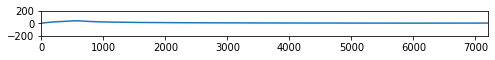

In [981]:
fig = plt.figure()

ax1 = fig.add_subplot(111, aspect='equal')

plt.plot(df_body['eta[1] [6 real output]'], df_body['eta[2] [7 real output]'])

plt.ylim(-200, 200)
plt.xlim(0, 7_200)

In [982]:
df_body['eta[2] [7 real output]']

0        0.000000
1        0.000000
2        0.000076
3        0.000339
4        0.000789
           ...   
13796    5.343820
13797    5.346430
13798    5.349000
13799    5.351540
13800    5.354040
Name: eta[2] [7 real output], Length: 13801, dtype: float64

### Velocity

11.67


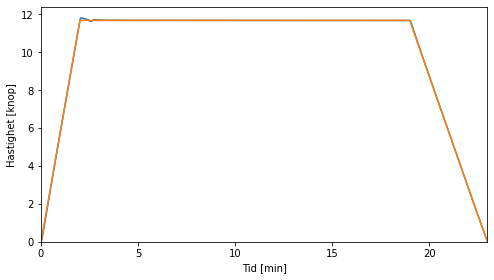

In [983]:
plt.plot(t / 60, U / 0.514444444)

plt.plot(df_speed['Time'] / 60, df_speed['target_speed [11 real input]'] / 0.5144444444, 
         label='Tilsvarende driftsprofil i simuleringer')

U_transit = np.interp(15 * 60, df_speed['Time'], U)

print(np.round(U_transit / 0.514444444, 2))

plt.ylim(0, None)
plt.xlim(0, 23)

plt.xlabel('Tid [min]')
plt.ylabel('Hastighet [knop]')

plt.savefig('driftsprofil_hastighet.png', dpi=300, bbox_inches='tight')

In [984]:
t.to_numpy()[-1] / 60

23.0

### Heading

(0.0, 24.0)

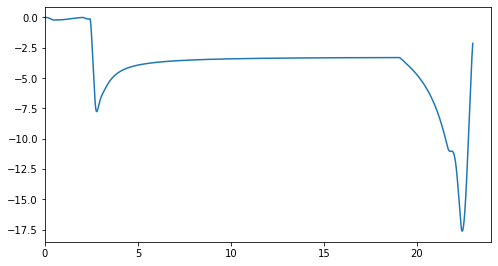

In [985]:
plt.plot(df_body['Time'] / 60, df_body['eta[6] [11 real output]'] * 180 / np.pi)
plt.xlim(0, 24)

In [986]:
np.sqrt(200**2 + (7200/2)**2)*2

7211.102550927979

## Thruster

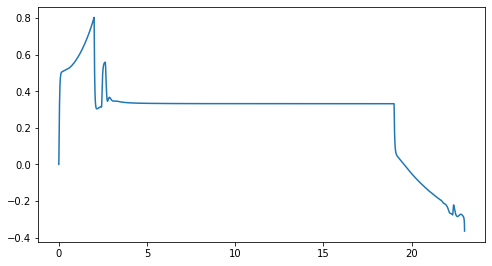

In [987]:
plt.plot(df_thruster['Time'] / 60, df_thruster['loading [102 real input]'])

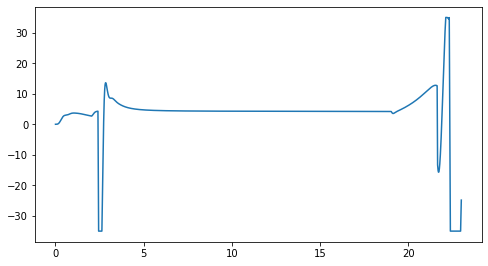

In [988]:
plt.plot(df_thruster['Time'] / 60, df_thruster['angle [101 real input]'] * 180 / np.pi)

In [989]:
df_heading.columns

Index(['Time', 'StepCount', 'k_p [1 real parameter]', 'k_i [2 real parameter]',
       'k_d [3 real parameter]', 'min_angle [4 real parameter]',
       'max_angle [5 real parameter]', 'target_heading [11 real input]',
       'estimated_heading [12 real input]', 'manual_angle [14 real input]',
       'gain_adjust [15 real input]', 'angle [21 real output]',
       'error [22 real output]', 'pid_on [13 boolean input]'],
      dtype='object')

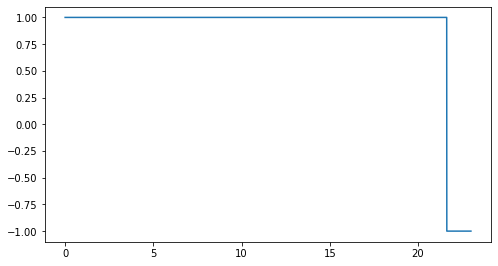

In [990]:
plt.plot(df_heading['Time'] / 60, df_heading['gain_adjust [15 real input]'])

### Wind loads

In [991]:
df_wind.columns

Index(['Time', 'StepCount', 'Parameters.A_Fw [1 real parameter]',
       'Parameters.A_Lw [2 real parameter]',
       'Parameters.CD_lAF [3 real parameter]',
       'Parameters.CD_t [4 real parameter]',
       'Parameters.H_Lw [5 real parameter]',
       'Parameters.L_oa [6 real parameter]',
       'Parameters.delta [7 real parameter]',
       'Parameters.kappa [8 real parameter]',
       'Parameters.rho_air [9 real parameter]',
       'Parameters.s_L [10 real parameter]', 'wind_direction [11 real input]',
       'wind_speed [12 real input]', 'eta[0] [13 real input]',
       'eta[1] [14 real input]', 'eta[2] [15 real input]',
       'eta[3] [16 real input]', 'eta[4] [17 real input]',
       'eta[5] [18 real input]', 'nu[0] [19 real input]',
       'nu[1] [20 real input]', 'nu[2] [21 real input]',
       'nu[3] [22 real input]', 'nu[4] [23 real input]',
       'nu[5] [24 real input]', 'tau_wind[0] [25 real output]',
       'tau_wind[1] [26 real output]', 'tau_wind[2] [27 real output]',


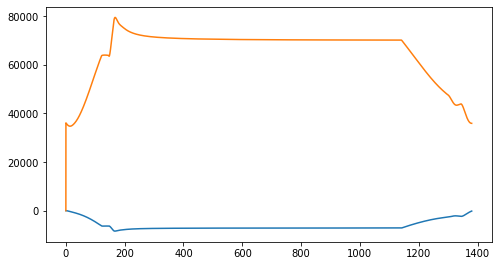

In [992]:
plt.plot(df_wind['Time'], df_wind['tau_wind[0] [25 real output]'])
plt.plot(df_wind['Time'], df_wind['tau_wind[1] [26 real output]'])

## Rudder

In [993]:
df_rudder.columns

Index(['Time', 'StepCount', 'density [1 real parameter]',
       'kinematic_viscosity [2 real parameter]', 'area [3 real parameter]',
       'chord [4 real parameter]', 'longitudinal_position [5 real parameter]',
       'ship_length [6 real parameter]',
       'effective_aspect_ratio_lift [7 real parameter]',
       'effective_aspect_ratio_drag [8 real parameter]',
       'cd_k [9 real parameter]', 'cd_a2 [10 real parameter]',
       'cl_stall [11 real parameter]', 'w0 [12 real parameter]',
       'gamma_positive [13 real parameter]',
       'gamma_negative [14 real parameter]', 'lr_surge [16 real parameter]',
       'lr_sway [17 real parameter]', 'tr [18 real parameter]',
       'ah [19 real parameter]', 'xh [20 real parameter]',
       'ship_velocity_surge [101 real input]',
       'ship_velocity_sway [102 real input]',
       'ship_velocity_yaw [103 real input]', 'angle [104 real input]',
       'surge_velocity_increase_factor [105 real input]',
       'force_surge [201 real output]

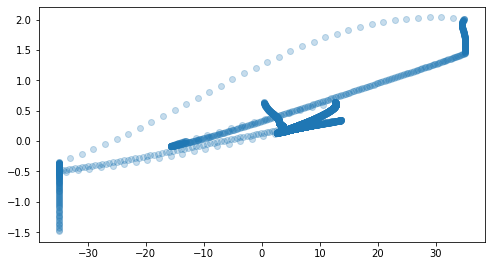

In [994]:
area_  = df_rudder['area [3 real parameter]'].to_numpy()[-1]
rho_   = df_rudder['density [1 real parameter]'].to_numpy()[-1]

angle_ = df_rudder['angle [104 real input]'].to_numpy()
u_     = df_rudder['ship_velocity_surge [101 real input]'].to_numpy()
v_     = df_rudder['ship_velocity_sway [102 real input]'].to_numpy()

w0_ = df_rudder['w0 [12 real parameter]'].to_numpy()[-1]

U_ = np.sqrt(u_**2 + v_**2)

indices = np.where(U_ > 0.5)

sway_force = df_rudder['force_sway [202 real output]'].to_numpy()

CL = sway_force[indices] / (0.5 * area_ * rho_ * U_[indices]**2)

plt.scatter(angle_[indices] * 180 / np.pi,  -CL, alpha=0.25)

#plt.ylim(0, 1.5)

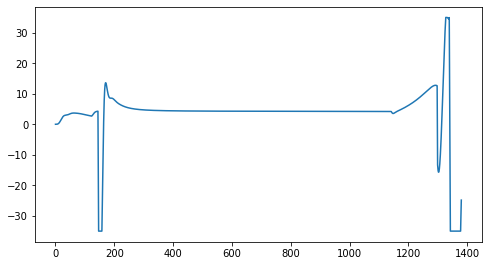

In [995]:
plt.plot(df_rudder['Time'], df_rudder['angle [104 real input]'] * 180 / np.pi)

In [996]:
df_thruster.columns

Index(['Time', 'StepCount', 'p0_x [1 real parameter]',
       'p0_y [2 real parameter]', 'orientation0_x [3 real parameter]',
       'orientation0_y [4 real parameter]', 'max_thrust [5 real parameter]',
       'angle [101 real input]', 'loading [102 real input]',
       'force_surge [201 real output]', 'force_sway [202 real output]',
       'moment_yaw [203 real output]'],
      dtype='object')

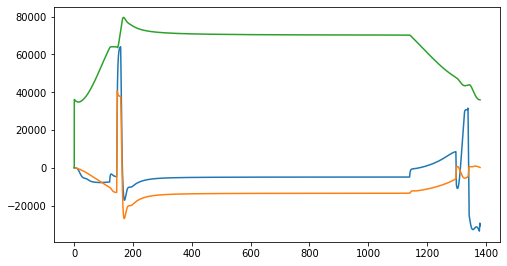

In [997]:
plt.plot(df_thruster['Time'], df_thruster['force_sway [202 real output]'])
plt.plot(df_rudder['Time'],   df_rudder['force_sway [202 real output]'])

plt.plot(df_wind['Time'], df_wind['tau_wind[1] [26 real output]'])

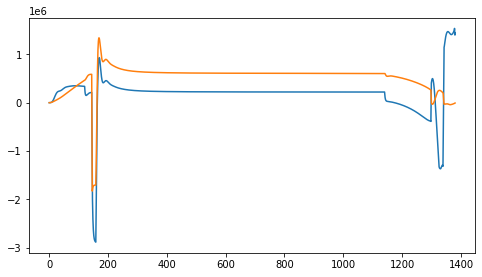

In [970]:
plt.plot(df_thruster['Time'], df_thruster['moment_yaw [203 real output]'])
plt.plot(df_rudder['Time'],   df_rudder['moment_yaw [203 real output]'])

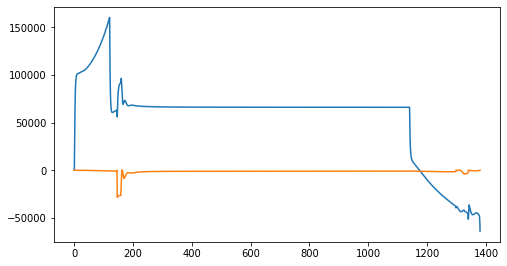

In [971]:
plt.plot(df_thruster['Time'], df_thruster['force_surge [201 real output]'])
plt.plot(df_rudder['Time'],   df_rudder['force_surge [201 real output]'])